## Helper functions and imports
We will define several helper functions that will be invoked repeatedly.
1. **_to_tensor(...)**: maps its argument to a tensor

2. **_normalize(...):** L2 normalizes a set of vectors

3. **sample_uniform_sphere(...):** generates a (batch of) uniformly random vector on the surface of the d dimensional sphere

4. **sample_uniform_orthogonal(...):** generates a uniformly random vector on the surface of the d dimensional sphere orthgonal to a given vector

5. **_as_schedule_tensor(...):** converts its argument to a tensor

6. **find_index(...):** find largest index of a vector such that the cumulative sum of prior entries does not exceed a given value

In [25]:
from dataclasses import dataclass
from typing import Optional, Union
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

device_default = "cpu"
# device_default = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE_DEFAULT = torch.float32

def _to_tensor(x, device, dtype):
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    return torch.as_tensor(x, device=device, dtype=dtype)


def _normalize(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    n = torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)
    return v / n


def sample_uniform_sphere(bsz: int, d: int, device, dtype) -> torch.Tensor:
    g = torch.randn((bsz, d), device=device, dtype=dtype)
    return _normalize(g)


def sample_uniform_orthogonal(theta: torch.Tensor) -> torch.Tensor:
    B, d = theta.shape
    g = torch.randn_like(theta)
    proj = (g * theta).sum(dim=-1, keepdim=True)
    g_ortho = g - proj * theta
    nrm = torch.linalg.vector_norm(g_ortho, dim=-1, keepdim=True)
    mask = (nrm.squeeze(-1) < 1e-9)
    if mask.any():
        g2 = torch.randn((mask.sum(), d), device=theta.device, dtype=theta.dtype)
        proj2 = (g2 * theta[mask]).sum(dim=-1, keepdim=True)
        g2 = g2 - proj2 * theta[mask]
        g_ortho[mask] = g2
    return _normalize(g_ortho)

def _as_schedule_tensor(spec, T: int, device, dtype):
    if isinstance(spec, (float, int)):
        return torch.full((T,), float(spec), device=device, dtype=dtype)
    t = _to_tensor(spec, device, dtype).flatten()
    if t.numel() != T:
        raise ValueError(f"Schedule length {t.numel()} != T={T}")
    return t

def find_index(v, value):
    cs = np.cumsum(v)
    idx = np.searchsorted(cs, value, side="right") - 1
    return max(idx, -1)   # returns -1 if even the first element exceeds value



## Link functions

Here we will define some link functions that can be invoked as well as their derivatives,
1. Linear function, $f(x) = x$ with derivative $f'(x) = 1$.
2. Cubuc function, $f(x) = x^3$ with derivative $f'(x) = 3x^2$.
4. Logistic function $f(x) = \frac{1}{1+e^{-x}}$ with derivative $f'(x) = f(x) ( 1 - f(x))$

In [26]:
class Link:
    @staticmethod
    def identity(z): return z
    @staticmethod
    def identity_prime(z): return torch.ones_like(z)
    @staticmethod
    def cubic(z): return z ** 3
    @staticmethod
    def cubic_prime(z): return 3 * z ** 2
    @staticmethod
    def logistic(z): return torch.sigmoid(z)
    @staticmethod
    def logistic_prime(z):
        s = torch.sigmoid(z)
        return s * (1 - s)


## Config dataclass

We will define the config for our experiment below, which is mainly specified by,
1. The dimension, $d$,
2. The burn-in period *T_burnin*, which is computed based on the properties of $f$,
3. The learning period *T_learning*,
4. The learning rate schedule for the burn-in period *eta_burnin_schedule*, computed based on the properties of $f$,
5. The sigma schedule for the burn-in period *sigma_burnin_schedule*,
6. The learning rate schedule for the learning period *eta_learning_schedule*,
7. The sigma schedule for the learning period *eta_learning_schedule*,
8. An initial parameter *theta0* which captures the initial point; if it is *None*, we initialize it so that $\langle \theta^\star , \theta_0 \rangle = 1/\sqrt{d}$.
9. The number of trials *num_runs*

In [27]:
@dataclass
class BanditConfig:
    d: int = 16
    T_burnin: int = 0
    T_learning: int = 20000
    eta_burnin_schedule: Union[float, list, torch.Tensor] = 0.1
    sigma_burnin_schedule: Union[float, list, torch.Tensor] = 0.5
    eta_learning_schedule: Union[float, list, torch.Tensor] = 0.05
    sigma_learning_schedule: Union[float, list, torch.Tensor] = 0.2
    f: callable = Link.identity
    fprime: callable = Link.identity_prime
    theta0: Optional[torch.Tensor] = None
    num_runs: int = 1
    seed: int = 0
    device: str = device_default
    dtype: torch.dtype = DTYPE_DEFAULT
    track_trajectory: bool = True

## Simulator
The *NonlinearBanditSGD_GPU* class simulates stochastic gradient descent and defines the initialization scheme for theta0, constructs burn-in phase eta and sigma sequences

In [28]:
class NonlinearBanditSGD_GPU:
    def __init__(self, cfg: BanditConfig):
        self.cfg = cfg
        self.device = cfg.device
        self.dtype = cfg.dtype

        torch.manual_seed(cfg.seed)
        if self.device.startswith("cuda"):
            torch.cuda.manual_seed_all(cfg.seed)

        self.B = cfg.num_runs
        self.d = cfg.d

        self.build_burnin_schedule(cfg)
        self.T_learning = cfg.T_learning
        self.T_total = self.T_burnin + self.T_learning

        self.eta_learn = _as_schedule_tensor(cfg.eta_learning_schedule, self.T_learning, self.device, self.dtype)
        self.sig_learn = _as_schedule_tensor(cfg.sigma_learning_schedule, self.T_learning, self.device, self.dtype)

        self.f = cfg.f
        self.fprime = cfg.fprime

        self.theta_star = sample_uniform_sphere(self.B, self.d, self.device, self.dtype)

        if cfg.theta0 is not None:
            th0 = _to_tensor(cfg.theta0, self.device, self.dtype)
            if th0.ndim == 1:
                th0 = th0.expand(self.B, -1)
            assert th0.shape == (self.B, self.d)
            self.theta = _normalize(th0)
        else:
            g = torch.randn((self.B, self.d), device=self.device, dtype=self.dtype)
            g = g - (g * self.theta_star).sum(dim=-1, keepdim=True) * self.theta_star
            g = _normalize(g)
            self.theta = _normalize((1.0 / (self.d ** 0.5)) * self.theta_star + (1.0 - 1.0 / self.d) ** 0.5 * g)

        self.f1 = self.f(torch.ones((self.B,), device=self.device, dtype=self.dtype))

        if cfg.track_trajectory:
            self.theta_hist = torch.empty((self.T_total + 1, self.B, self.d), device=self.device, dtype=self.dtype)
            self.theta_hist[0] = self.theta
            self.x_hist = torch.empty((self.T_total, self.B, self.d), device=self.device, dtype=self.dtype)
            self.r_hist = torch.empty((self.T_total, self.B), device=self.device, dtype=self.dtype)
            self.inst_regret_hist = torch.empty((self.T_total, self.B), device=self.device, dtype=self.dtype)
            self.angle_err_hist = torch.empty((self.T_total, self.B), device=self.device, dtype=self.dtype)
        else:
            self.theta_hist = self.x_hist = self.r_hist = self.inst_regret_hist = self.angle_err_hist = None

        self.cum_regret = torch.zeros((self.B,), device=self.device, dtype=self.dtype)
        


    def build_burnin_schedule(self, cfg):
        d = cfg.d
        fprime = cfg.fprime
        k = np.arange(1, d)
        m = 0.99 * np.sqrt(k / d)
        eta = 0.1 * fprime(m) / (d * m)
        z = np.concatenate([[0.0], m[:-1]])
        Delta = 10.0 * d * (m - z) / (eta * fprime(m))
        self.T_burnin = int(np.sum(Delta))
        cfg.T_burnin = self.T_burnin
        cum_Delta = np.cumsum(Delta)
        t_grid = np.arange(self.T_burnin)
        k_idx = np.searchsorted(cum_Delta, t_grid, side="right")
        eta_schedule = eta[np.clip(k_idx, 0, len(eta) - 1)]
        sig_schedule = 0.2 * np.ones_like(eta_schedule)
        self.sig_burn = _as_schedule_tensor(sig_schedule, self.T_burnin, self.device, self.dtype)
        self.eta_burn = _as_schedule_tensor(eta_schedule, self.T_burnin, self.device, self.dtype)


    @torch.no_grad()
    def get_phase_params(self, t: int):
        if t <= self.T_burnin:
            idx = t - 1
            return self.eta_burn[idx], self.sig_burn[idx]
        else:
            idx = t - 1 - self.T_burnin
            return self.eta_learn[idx], self.sig_learn[idx]

    @torch.no_grad()
    def step(self, t: int):
        eta_t, sigma_t = self.get_phase_params(t)
        eta_t = eta_t.view(-1, 1)
        sigma_t = sigma_t.view(-1, 1)

        Z_t = sample_uniform_orthogonal(self.theta)
        x_t = _normalize(torch.sqrt(1.0 - sigma_t ** 2) * self.theta + sigma_t * Z_t)

        dot_star = (self.theta_star * x_t).sum(dim=-1)
        true_mean = self.f(dot_star)
        r_t = true_mean + torch.randn_like(true_mean)

        a_t = x_t
        v = (self.theta * a_t).sum(dim=-1)
        f_theta_at = self.f(v)
        err = f_theta_at - r_t
        fp = self.fprime(v)

        tangent_component = a_t - v.unsqueeze(-1) * self.theta
        scalar = eta_t * (err * fp).view(-1, 1)
        theta_half = self.theta - scalar * tangent_component

        theta_next = _normalize(theta_half)
        inst_regret = self.f1 - true_mean
        self.cum_regret += inst_regret

        if self.cfg.track_trajectory:
            self.x_hist[t - 1] = x_t
            self.r_hist[t - 1] = r_t
            self.inst_regret_hist[t - 1] = inst_regret
            cosang = (theta_next * self.theta_star).sum(dim=-1).clamp(-1.0, 1.0)
            self.angle_err_hist[t - 1] = cosang
            self.theta_hist[t] = theta_next

        self.theta = theta_next

    @torch.no_grad()
    def run(self):
        for t in range(1, self.T_total + 1):
            self.step(t)
        return self.summary()

    @torch.no_grad()
    def summary(self):
        out = {
            "theta_star": self.theta_star.cpu().numpy(),
            "theta_final": self.theta.cpu().numpy(),
            "cum_regret": self.cum_regret.cpu().numpy(),
        }
        if self.cfg.track_trajectory:
            out.update({
                "theta_path": self.theta_hist.cpu().numpy(),
                "actions": self.x_hist.cpu().numpy(),
                "rewards": self.r_hist.cpu().numpy(),
                "inst_regret": self.inst_regret_hist.cpu().numpy(),
                "angle_error": self.angle_err_hist.cpu().numpy(),
                "cum_regret_over_time": self.inst_regret_hist.cumsum(dim=0).cpu().numpy(),
            })
        return out


## Execution and plotter helper functions
We define a helper function *run_experiments_gpu* for invoking SGD by instantiating the NonlinearBanditSGD_GPU accordingly, and tracking various quantities of interest, such as the instantaneous regret $f(1) - f (\langle \theta_t, \theta^\star \rangle)$ as well as the correlation $\langle \theta_t, \theta^\star \rangle$. We also define a helper function *plot_training_dynamics* to carry out plotting of these quantities after executing SGD.

In [ ]:
def run_experiments_gpu(cfg: BanditConfig):
    sim = NonlinearBanditSGD_GPU(cfg)
    out = sim.run()
    T_total = cfg.T_burnin + cfg.T_learning
    tgrid = torch.arange(1, T_total + 1, device=cfg.device)

    if cfg.track_trajectory:
        inst = out["inst_regret"]
        angle = out["angle_error"]
        cum_t = out["cum_regret_over_time"]

        corr = np.mean(angle, axis=1)
        corr_std = np.std(angle, axis=1)

        stats = {
            "dimension": cfg.d,
            "T_burnin": cfg.T_burnin,
            "T_learning": cfg.T_learning,
            "tgrid": tgrid.cpu().numpy(),
            "cum_mean": cum_t.mean(axis=1).astype(np.float32),
            "cum_std": cum_t.std(axis=1).astype(np.float32),
            "inst_mean": inst.mean(axis=1).astype(np.float32),
            "inst_std": inst.std(axis=1).astype(np.float32),
            "corr_mean": corr.astype(np.float32),
            "corr_std": corr_std.astype(np.float32),
        }
        return stats
    else:
        cum = out["cum_regret"]
        stats = {
            "dimension": cfg.d,
            "T_burnin": cfg.T_burnin,
            "T_learning": cfg.T_learning,
            "tgrid": torch.arange(1, T_total + 1).cpu().numpy(),
            "cum_mean": np.full(T_total, cum.mean().item()),
            "cum_std": np.full(T_total, cum.std().item()),
            "inst_mean": None,
            "inst_std": None,
            "corr_mean": None,
            "corr_std": None,
        }
        return stats

# -----------------------------
# Plotting (fixed correlation)
# -----------------------------

def plot_training_dynamics(stats):
    t = stats["tgrid"]
    cum_mean, cum_std = stats["cum_mean"], stats["cum_std"]
    corr_mean, corr_std = stats["corr_mean"], stats["corr_std"]
    T_burnin = stats.get("T_burnin", None)  # optional, if stored in stats

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # --- Alignment evolution (E[θ]) ---
    ax[0].plot(t, corr_mean, label="Correlation")
    ax[0].fill_between(t, corr_mean - corr_std, corr_mean + corr_std, alpha=0.2)

    if T_burnin is not None:
        ax[0].axvline(x=T_burnin, color="C3", linestyle="--", linewidth=1.5, label=f"T_burnin = {T_burnin}")

    ax[0].set_title("Correlation as a function of time")
    ax[0].set_xlabel(r'Iteration $t$')
    ax[0].set_ylabel(r'$\langle \theta_t, \theta^\star \rangle$')
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()

    # --- You can add the cumulative regret subplot as well if desired ---
    ax[1].plot(t, cum_mean, label="Cumulative regret", color="C0")
    ax[1].fill_between(t, cum_mean - cum_std, cum_mean + cum_std, alpha=0.2, color="C0")

    if T_burnin is not None:
        ax[1].axvline(x=T_burnin, color="C3", linestyle="--", linewidth=1.5)

    ax[1].set_title("Cumulative regret as a function of time")
    ax[1].set_xlabel(r'Iteration $t$')
    ax[1].set_ylabel(r'Cumulative regret')
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


## Execution
The learning phase sigma and eta schedules are defined as $\eta_t \asymp \min \big\{ \frac{1}{\sqrt{t}} , \frac{1}{d}, 0.01 \big\}$ and $\sigma_t \asymp \big\{ \frac{d}{\sqrt{t}}, 0.2 \big\}$. 

{'dimension': <class 'int'>, 'T_burnin': <class 'int'>, 'T_learning': <class 'int'>, 'tgrid': (54756,), 'cum_mean': (54756,), 'cum_std': (54756,), 'inst_mean': (54756,), 'inst_std': (54756,), 'corr_mean': (54756,), 'corr_std': (54756,)}


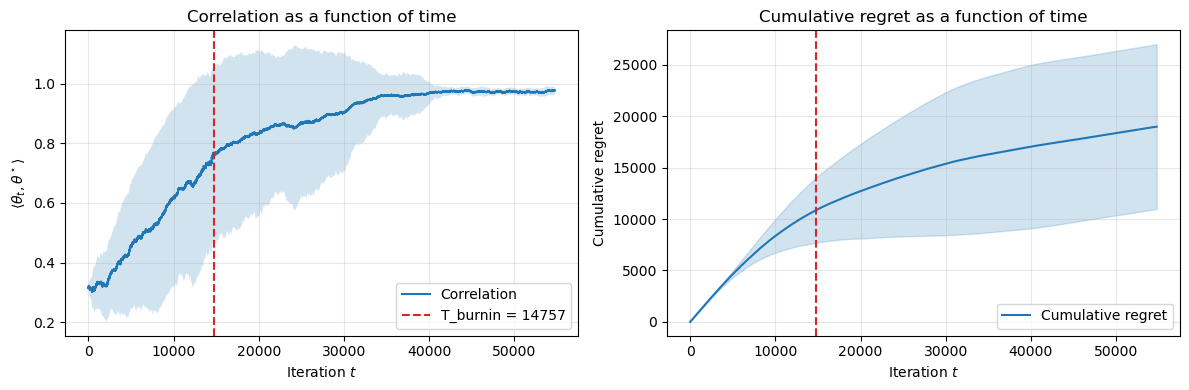

In [30]:
# set dimension and constants
d = 10

# Define learning rate and sigma schedules for the learning phase
C = 5000.0
T_learning = int(d**2/(0.05**2))
sigma_learning_schedule = [ min( d/np.sqrt(t/C+1), 0.2 ) for t in range(T_learning)]
eta_learning_schedule = [ min( 1.0/np.sqrt(t/C+1), 0.01 )for t in range(T_learning)]

# Execute num_runs x SGD runs
if __name__ == "__main__":
    cfg = BanditConfig(
        d=d,
        T_learning=T_learning,
        eta_learning_schedule=eta_learning_schedule,
        sigma_learning_schedule=sigma_learning_schedule,
        f=Link.cubic,
        fprime=Link.cubic_prime,
        num_runs=20,
        seed=777,
        device=device_default,
        dtype=torch.float32,
        track_trajectory=True,
    )

    stats = run_experiments_gpu(cfg)
    print({k: (None if v is None else (v.shape if hasattr(v, 'shape') else type(v))) for k, v in stats.items()})
    plot_training_dynamics(stats)
